# Preproccesing

In [ ]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=a3f16ecd4f6267897e85404a4fe7239570715b72e1f143627b254f244b3e97f5
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from pathlib import Path
from glob import glob
import os
from PIL import Image
import tensorflow as tf
from medmnist import BreastMNIST
from tensorflow import keras
from keras import layers
import random

In [ ]:
train_data = BreastMNIST(split = 'train', download = True)
test_data = BreastMNIST(split = 'test', download = True)
val_data = BreastMNIST(split = 'val', download = True)

100%|██████████| 559580/559580 [00:00<00:00, 739986.31it/s]

Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz


In [ ]:
train_data

Dataset BreastMNIST (breastmnist)
    Number of datapoints: 546
    Root location: /root/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0

[1]


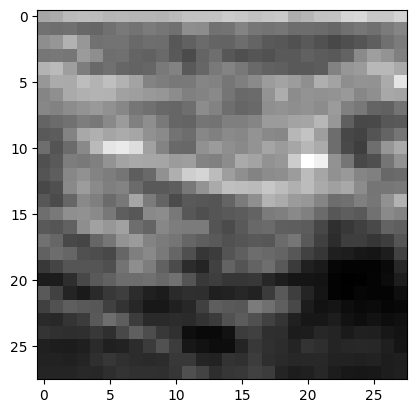

In [ ]:
rand = random.randint(0,510)
plt.imshow(train_data.imgs[rand],cmap = 'gray')
print(train_data.labels[rand])

In [ ]:
train_imgs = train_data.imgs
train_imgs = np.array(train_imgs)/255.
train_labels = train_data.labels


test_imgs = test_data.imgs
test_imgs = np.array(test_imgs)/255.
test_labels = test_data.labels

val_imgs = val_data.imgs
val_imgs = np.array(val_imgs)/255.
val_labels = val_data.labels

all_imgs = np.concatenate((train_imgs, test_imgs,val_imgs),0)
all_labels = np.concatenate((train_labels, test_labels, val_labels),0)

# tf
cat_train_labels = keras.utils.to_categorical(train_labels, 2)
train_imgs = np.reshape(train_imgs, (-1, 28, 28, 1))

In [ ]:
img_size = 28
batch_size = 64

# CNN model

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.Resizing(32,32),
])

In [ ]:
base_model = tf.keras.applications.ResNet50(input_shape=(32,32,1),
                                               include_top=False,
                                               weights=None)

In [ ]:
head_model = tf.keras.models.Sequential()
head_model.add(tf.keras.layers.GlobalAveragePooling2D())
head_model.add(tf.keras.layers.Dense(256, activation='elu'))
head_model.add(tf.keras.layers.Dropout(0.3))
head_model.add(tf.keras.layers.Dense(32, activation='elu'))
head_model.add(tf.keras.layers.Dropout(0.3))
head_model.add(tf.keras.layers.Dense(1 , activation='sigmoid'))


In [ ]:
inputs = tf.keras.Input(shape=(28, 28, 1))
x = data_augmentation(inputs)
x = base_model(x)
outputs = head_model(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 sequential (Sequential)     (None, 32, 32, 1)         0         
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23581440  
                                                                 
 sequential_1 (Sequential)   (None, 1)                 532801    
                                                                 
Total params: 24114241 (91.99 MB)
Trainable params: 24061121 (91.79 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), metrics = ['accuracy'])

batch_size = 32
epochs = 40
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.6,
                              patience=1,
                              verbose=0, min_lr=1e-7)

In [ ]:
history = model.fit(train_imgs, train_labels,
          batch_size = batch_size,
          epochs = epochs,
          verbose = 1,
          validation_data = (test_imgs, test_labels),
          callbacks=[reduce_lr])

Epoch 1/40
18/18 [==============================] - 59s 246ms/step - loss: 1.5987 - accuracy: 0.6117 - val_loss: 0.5913 - val_accuracy: 0.7308 - lr: 0.0100
Epoch 2/40
18/18 [==============================] - 1s 67ms/step - loss: 0.6327 - accuracy: 0.7106 - val_loss: 0.5888 - val_accuracy: 0.7308 - lr: 0.0100
Epoch 3/40
18/18 [==============================] - 1s 51ms/step - loss: 0.6132 - accuracy: 0.7253 - val_loss: 0.5860 - val_accuracy: 0.7308 - lr: 0.0060
Epoch 4/40
18/18 [==============================] - 1s 46ms/step - loss: 0.6119 - accuracy: 0.7070 - val_loss: 0.5853 - val_accuracy: 0.7308 - lr: 0.0036
Epoch 5/40
18/18 [==============================] - 1s 46ms/step - loss: 0.6415 - accuracy: 0.6978 - val_loss: 0.5832 - val_accuracy: 0.7308 - lr: 0.0022
Epoch 6/40
18/18 [==============================] - 1s 46ms/step - loss: 0.6195 - accuracy: 0.7015 - val_loss: 0.5836 - val_accuracy: 0.7308 - lr: 0.0013
Epoch 7/40
18/18 [==============================] - 1s 46ms/step - loss: 0

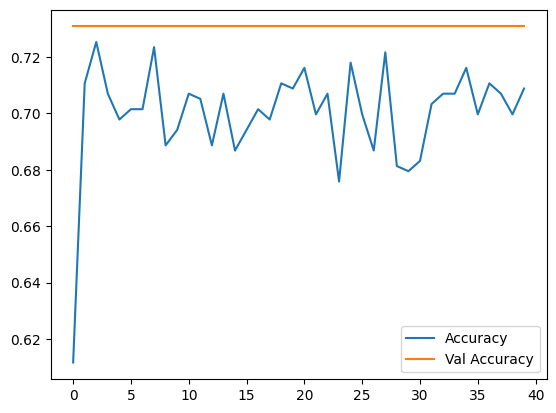

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Accuracy', 'Val Accuracy'])

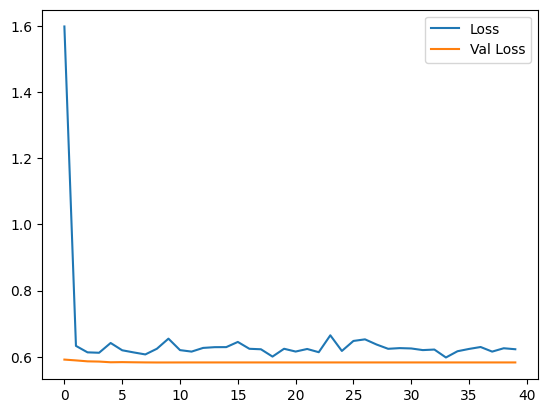

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Val Loss'])

5/5 [==============================] - 1s 15ms/step
Accuracy is 0.7307692307692307
Presicion is 0.7307692307692307
F1 score is 0.8444444444444443


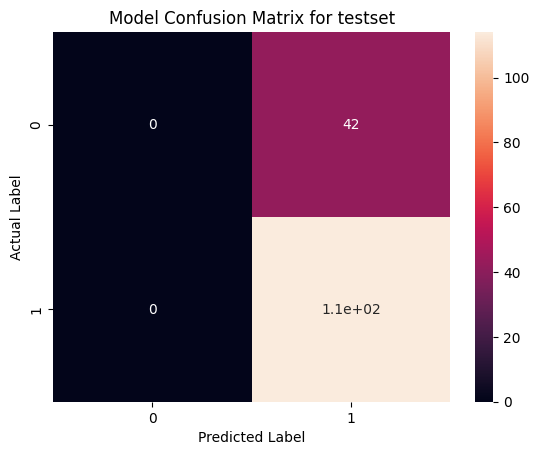

In [ ]:
import numpy as np
y_predict = model.predict(test_imgs)
y_predict=np.round(y_predict)
from sklearn.metrics import confusion_matrix
import seaborn as sns
model_cm=confusion_matrix(test_labels,y_predict)
sns.heatmap(model_cm, annot=True)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Model Confusion Matrix for testset');
from sklearn.metrics import f1_score, precision_score, accuracy_score, confusion_matrix
Accuracy  = accuracy_score(test_labels, y_predict)
precision  = precision_score(test_labels, y_predict)
f1_Score = f1_score(test_labels, y_predict)
print(f'Accuracy is {Accuracy }')
print(f'Presicion is {precision }')
print(f'F1 score is {f1_Score}')

# TF GAN

In [ ]:
batch_size = 64
num_channels = 1
num_classes = 2
image_size = 28
latent_dim = 128
LR = 0.00001

In [ ]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

130 3


In [ ]:
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((28, 28, discriminator_in_channels)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.ReLU(),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.ReLU(),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),],
      name="discriminator",
)

generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        layers.Dense(7 * 7 * generator_in_channels),
        layers.ReLU(),
        layers.Reshape((7, 7, generator_in_channels)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.ReLU(),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.ReLU(),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [ ]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 6370)              834470    
                                                                 
 re_lu_2 (ReLU)              (None, 6370)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 130)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 128)       266368    
 anspose)                                                        
                                                                 
 re_lu_3 (ReLU)              (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 128)       262272    
 Transpose)                                              

In [ ]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1792      
                                                                 
 re_lu (ReLU)                (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 re_lu_1 (ReLU)              (None, 7, 7, 128)         0         
                                                                 
 global_max_pooling2d (Glob  (None, 128)               0         
 alMaxPooling2D)                                                 
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                     

In [ ]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        real_images, one_hot_labels = data

        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size])
        image_one_hot_labels = tf.reshape(image_one_hot_labels, (-1, image_size, image_size, num_classes))


        batch_size = tf.shape(real_images)[0]
        z_vector = tf.random.normal(shape=(batch_size, self.latent_dim))
        z_vector_labels = tf.concat([z_vector, one_hot_labels], axis=1)


        generated_images = self.generator(z_vector_labels)

        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat([fake_image_and_labels, real_image_and_labels], axis=0)

        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )


        z_vector = tf.random.normal(shape=(batch_size, self.latent_dim))
        z_vector_labels = tf.concat([z_vector, one_hot_labels], axis=1)

        fake_labels = tf.zeros((batch_size, 1))

        # Train the generator
        with tf.GradientTape() as tape:
            fake_images = self.generator(z_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(fake_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),}


In [ ]:
cond_gan = ConditionalGAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=LR),
    g_optimizer=keras.optimizers.Adam(learning_rate=LR),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True))

history = cond_gan.fit(train_imgs, cat_train_labels, epochs=1000, verbose = 0)

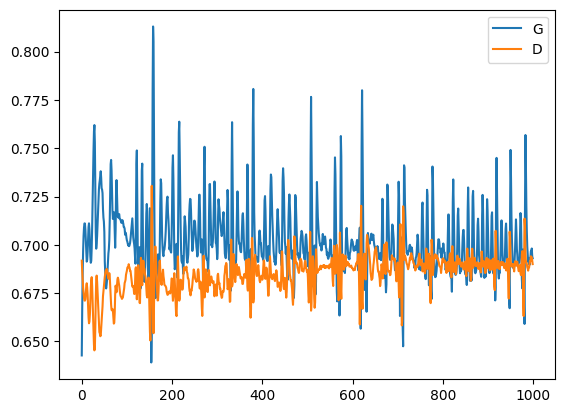

In [ ]:
plt.plot(history.history['g_loss'])
plt.plot(history.history['d_loss'])
plt.legend(['G','D'])

# Generating new data

In [ ]:
n_train = train_labels.shape[0]
n_ones = 399
n_zeros = int(n_train - n_ones)
n_new_samples_ones = int(500 - n_ones)
n_new_samples_zeros = int(500 - n_zeros)
size_z = 100

In [ ]:
ones_noise = tf.random.normal(shape=(n_new_samples_ones, latent_dim))
ones_label = tf.reshape(tf.Variable([0., 1.]*n_new_samples_ones, dtype = float),(-1,2))
ones_noise_and_labels = tf.concat([ones_noise, ones_label], 1)

zeros_noise = tf.random.normal(shape=(n_new_samples_zeros, latent_dim))
zeros_label = tf.reshape(tf.Variable([1., 0.]*n_new_samples_zeros, dtype = float),(-1,2))
zeros_noise_and_labels = tf.concat([zeros_noise, zeros_label], 1)

generated_ones = cond_gan.generator.predict(ones_noise_and_labels, verbose = 0)
generated_zeros =  cond_gan.generator.predict(zeros_noise_and_labels, verbose = 0)

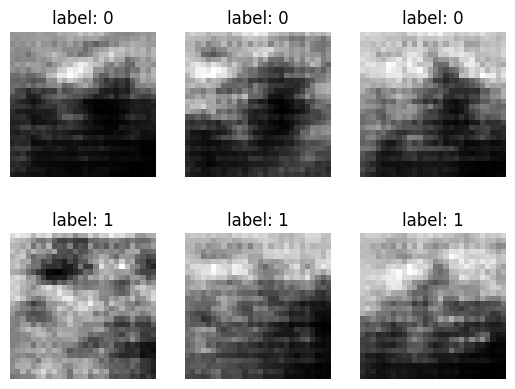

In [ ]:
for i in range(3):
  plt.subplot(2, 3, i+1)
  plt.imshow(generated_zeros[i], cmap = 'gray')
  plt.title('label: 0')
  plt.axis('off')
  plt.subplot(2, 3, i+4)
  plt.imshow(generated_ones[i], cmap = 'gray')
  plt.title('label: 1')
  plt.axis('off')


In [ ]:
new_ones_label = np.ones((n_new_samples_ones,1), dtype='uint8')
new_zeros_label = np.zeros((n_new_samples_zeros,1), dtype='uint8')

In [ ]:
new_train_imgs =  tf.concat((train_imgs, generated_ones,generated_zeros),0)
new_train_labels =  tf.concat((train_labels, new_ones_label, new_zeros_label),0)

In [ ]:
new_dataset_size = 1000

In [ ]:
tf.random.set_seed(1380)
new_train_imgs = tf.random.shuffle(new_train_imgs)[:new_dataset_size]
tf.random.set_seed(1380)
new_train_labels = tf.random.shuffle(new_train_labels)[:new_dataset_size]

# CNN model with generated data

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.Resizing(32,32)
])

In [ ]:
base_model = tf.keras.applications.ResNet50(input_shape=(32,32,1),
                                               include_top=False,
                                               weights=None)

In [ ]:
head_model = tf.keras.models.Sequential()
head_model.add(tf.keras.layers.GlobalAveragePooling2D())
head_model.add(tf.keras.layers.Dense(256, activation='elu'))
head_model.add(tf.keras.layers.Dropout(0.3))
head_model.add(tf.keras.layers.Dense(32, activation='elu'))
head_model.add(tf.keras.layers.BatchNormalization())
head_model.add(tf.keras.layers.Dropout(0.3))
head_model.add(tf.keras.layers.Dense(1 , activation='sigmoid'))


In [ ]:
inputs = tf.keras.Input(shape=(28, 28, 1))
x = data_augmentation(inputs)
x = base_model(x)
outputs = head_model(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 sequential_2 (Sequential)   (None, 32, 32, 1)         0         
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23581440  
                                                                 
 sequential_3 (Sequential)   (None, 1)                 532929    
                                                                 
Total params: 24114369 (91.99 MB)
Trainable params: 24061185 (91.79 MB)
Non-trainable params: 53184 (207.75 KB)
_________________________________________________________________


In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy'])

batch_size = 32
epochs = 40
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.6,
                              patience=1,
                              verbose=0, min_lr=1e-7)

In [ ]:
history = model.fit(new_train_imgs, new_train_labels,
          batch_size = batch_size,
          epochs = epochs,
          verbose = 1,
          validation_data = (test_imgs, test_labels),
          callbacks=[reduce_lr])

Epoch 1/40
32/32 [==============================] - 37s 158ms/step - loss: 0.6671 - accuracy: 0.6680 - val_loss: 0.6112 - val_accuracy: 0.7308 - lr: 0.0010
Epoch 2/40
32/32 [==============================] - 1s 45ms/step - loss: 0.4652 - accuracy: 0.8220 - val_loss: 0.5985 - val_accuracy: 0.7308 - lr: 0.0010
Epoch 3/40
32/32 [==============================] - 2s 47ms/step - loss: 0.3381 - accuracy: 0.8680 - val_loss: 0.5827 - val_accuracy: 0.7308 - lr: 6.0000e-04
Epoch 4/40
32/32 [==============================] - 1s 44ms/step - loss: 0.2807 - accuracy: 0.8960 - val_loss: 0.5821 - val_accuracy: 0.7308 - lr: 3.6000e-04
Epoch 5/40
32/32 [==============================] - 1s 44ms/step - loss: 0.2101 - accuracy: 0.9270 - val_loss: 0.5841 - val_accuracy: 0.7308 - lr: 2.1600e-04
Epoch 6/40
32/32 [==============================] - 1s 46ms/step - loss: 0.1705 - accuracy: 0.9510 - val_loss: 0.5747 - val_accuracy: 0.7308 - lr: 1.2960e-04
Epoch 7/40
32/32 [==============================] - 1s 46m

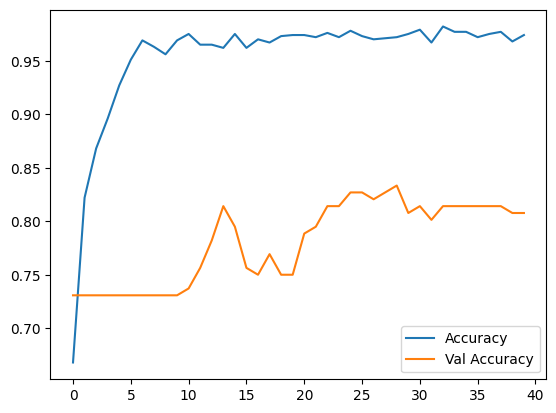

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Accuracy', 'Val Accuracy'])

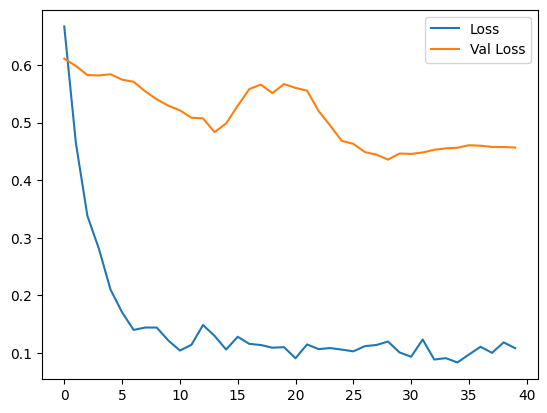

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Val Loss'])

5/5 [==============================] - 2s 17ms/step
Accuracy is 0.8076923076923077
Presicion is 0.875
F1 score is 0.8672566371681416


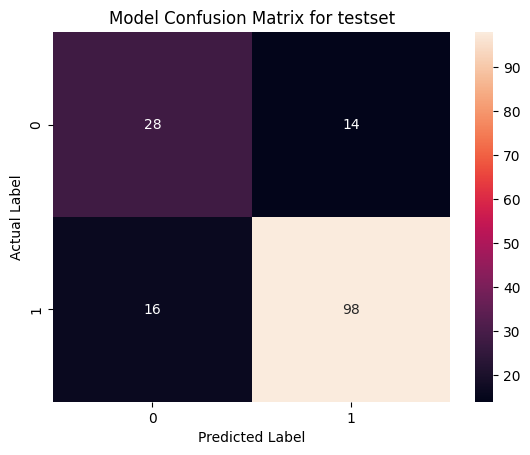

In [ ]:
import numpy as np
y_predict = model.predict(test_imgs)
y_predict=np.round(y_predict)
from sklearn.metrics import confusion_matrix
import seaborn as sns
model_cm=confusion_matrix(test_labels,y_predict)
sns.heatmap(model_cm, annot=True)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Model Confusion Matrix for testset');
from sklearn.metrics import f1_score, precision_score, accuracy_score, confusion_matrix
Accuracy  = accuracy_score(test_labels, y_predict)
precision  = precision_score(test_labels, y_predict)
f1_Score = f1_score(test_labels, y_predict)
print(f'Accuracy is {Accuracy }')
print(f'Presicion is {precision }')
print(f'F1 score is {f1_Score}')